# Building an Agent with LangGraph and Azure OpenAI: A Complete Guide

## Introduction

This tutorial will guide you through building an intelligent ordering system called BaristaBot using LangGraph and Azure OpenAI. The system will:
- Provide a natural language interface for cafe orders
- Maintain conversation state
- Handle complex order modifications
- Integrate with a menu system
- Process and validate orders

### Why LangGraph?

LangGraph is a powerful framework for building stateful, graph-based applications powered by language models. Key advantages include:
- Clear separation of concerns through nodes and edges
- Built-in state management
- Flexible routing between components
- Support for both synchronous and streaming operations
- Integration with various LLM providers

## Understanding LangGraph
LangGraph is a framework that helps you build applications with language models using a graph-based approach. Think of it like building blocks where each block has a specific job and they're connected in specific ways.

### Key Concepts


1. **Graphs**:  At its heart, LangGraph uses graphs. A graph is like a flowchart that shows how different parts of your application connect and work together.

2. **State**:  LangGraph keeps track of information as it moves through your application. This is called "state" and it's like a memory that holds things like:
   - The conversation history
   - Any important variables
   - The current status of the application

3. **Nodes**:  These are the building blocks of your application. Each node is like a worker that has a specific job. For example:
   - One node might talk to the language model
   - Another node might get input from the user
   - Another might update a database
   
   Python functions that encode the logic of your agents. They receive the current `State` as input, perform some computation or side-effect, and return an updated `State`.

4. **Edges**: These connect the nodes together and show how information flows between them. They determine things like:
   - What happens next after each step
   - When to stop or continue
   - Which path to take based on certain conditions

By composing `Nodes` and `Edges`, you can create complex, looping workflows that evolve the `State` over time. The real power, though, comes from how LangGraph manages that `State`. To emphasize: `Nodes` and `Edges` are nothing more than Python functions - they can contain an LLM or just good ol' Python code.

In short: `nodes` do the work. `edges` tell what to do next.

To start, install the LangGraph package:
```bash
%pip install langgraph
```

Let me show you a very simple example to illustrate these concepts:


In [1]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# 1. First, we define what information we want to track (State)
class SimpleState(TypedDict):
    message: str  # Just tracking a single message for now
    
# 2. Create a simple node that processes messages
def message_processor(state: SimpleState) -> SimpleState:
    """A simple node that adds 'Processed: ' to messages"""
    return {"message": f"Processed: {state['message']}"}

# 3. Build the graph
graph = StateGraph(SimpleState) # Tell the graph what data can flow through it
graph.add_node("processor", message_processor)  # Add our node
graph.add_edge(START, "processor")  # Connect start to our node
graph.add_edge("processor", END)    # Connect our node to end

simple_graph = graph.compile() # Compile the graph


It can be helpful to visualise the graph you just defined. The following code renders the graph.

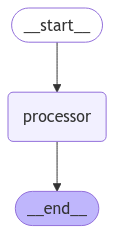

In [2]:
from IPython.display import Image, display

Image(simple_graph.get_graph().draw_mermaid_png())

## Setup and Installation

Requirements:
```bash
pip install langchain-openai
pip install azure-openai
```
### Configuration
Create a  `.env` file:

```python
AZURE_OPENAI_ENDPOINT="your_azure_endpoint"
AZURE_OPENAI_API_KEY="your_api_key"
OPENAI_API_VERSION="your_api_version"
```

In [3]:
from dotenv import load_dotenv
import os
from langchain_openai import AzureChatOpenAI

load_dotenv()

llm = AzureChatOpenAI(
    azure_deployment='gpt-4o',
    api_version=os.getenv("OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_KEY"),
    temperature=0.7,
    max_retries=3,
)

# test the llm
print(llm.invoke("Hello, how are you?"))


content="Hello! I'm just a computer program so I don't have feelings, but I'm here and ready to help you. How can I assist you today?" additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 13, 'total_tokens': 42, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_f3927aa00d', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 's

##  Building a BaristaBot Agent

### Introduction

BaristaBot is an interactive cafe ordering system that provides a natural language interface for customers to:

- Inquire about menu items
- Place and modify orders
- Confirm and process their orders

The system demonstrates key concepts of agent building using LangGraph including:

- State management
- Tool integration
- Conversation flow control
- Order processing

### System Components Overview

1. Statement Management System
    - Maintains conversation history
    - Tracks current order items
    - Handles order status
    - Manages completion flags

2. Conversation Handler
    - Processes user input
    - Generates appropriate responses
    - Routes to appropriate tools

3. Menu System
    - Provides menu information
    - validates menu items
    - handles menu inquires
    - Tracks availability

4. Order management System
    - Adds/removes items
    - Modifies orders
    - Confirms orders
    - Processes final orders

### Implementation Steps

**Step 1: Core State Definition**

State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here you define a state object, `OrderState`, that holds the conversation history, a structured order, and a flag indicating if the customer has finished placing their order. For simplicity, the "structure" in this order is just a list of strings, but this can be expanded to any Python data structure.

In Python, the LangGraph state object is a Python [dictionary](https://docs.python.org/3/library/stdtypes.html#dict). You can provide a schema for this dictionary by defining it as a [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict).

Let's first define how our system will maintain state:

In [4]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[List[str], add_messages]

    # The customer's in-process order.
    order: List[str]

    # A flag indicating if the customer has finished placing their order.
    finished: bool

Note that
- `Annotated` is a special type from the typing module that allows you to add extra metadata to type hints. e.g. 
    ```python
    UserId = Annotated[int, 'User ID must be an integer']
    user_id: UserId = 123
    ```
- `messages` uses `add_messages` annotation for automatic message appending
- `order` tracks ordered items and their modifiers
- `finished` controls conversation termination




### Step 2: System Instructions

Define the system prompt for the LLM.

In [5]:
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.

BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    """You are BaristaBot, an interactive cafe ordering system. A human will talk to you about the 
    available products you have and you will answer any questions about menu items (and only about 
    menu items - no off-topic discussion, but you can chat about the products and their history).
    The customer will place an order for 1 or more items from the menu, which you will structure 
    and send to the ordering system after confirming the order with the human.
    
    Add items to the customer's order with add_to_order, and reset the order with clear_order. 
    To see the contents of the order so far, call get_order (this is shown to you, not the user) 
    Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will display the order items to the user and returns their response to seeing the list. Their response may contain modifications. 
    Always verify and respond with drink and modifier names from the MENU before adding them to the order. 
    If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. 
    You only have the modifiers listed on the menu.
    Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make 
    any necessary updates and then call place_order. Once place_order has returned, thank the user and 
    say goodbye!
    """
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

This instruction:

- Defines the bot's role and capabilities
- Sets conversation boundaries
- Establishes interaction rules
- Ensures consistent behavior


### Step 3. Building Basic Chat Interface

Before diving into the code, let's understand what we need to build and why.

#### Components Needed:

1. **Chatbot Node**
    - **Purpose**: Central processing unit that handles LLM interactions
    - **Responsibilities**:
        - Processes incoming messages using Azure OpenAI
        - Manages initial greetings
        - Formats responses correctly
        - Manages conversation context
    - **Why**: We need this to handle the core conversation logic and LLM interactions

2. **Human Node**
    - **Purpose**: manages user interaction interface
    - **Responsibilities**:
        - Displays bot messages to user
        - Captures user input
        - Handles exit commands
        - Updates conversation state
    - **Why**: Creates separation between user interaction and bot processing

3. **Router**
    - **Purpose**: Controls conversation flow
    - **Responsibilities**:
        - Determines next steps based on state
        - Handles conversation endings
        - Manages transitions between nodes
    - **Why**: Ensures proper flow control and state transitions

#### How They Work Together
1. Flow Sequence

    START -> Chatbot (Welcome) -> Human (Input) -> Chatbot (Response) -> Human (Input) -> ... -> END

2. State Updates:
    - Each node receives current state
    - Process its part
    - Returns updated state
    - Never modifies existing state

#### Implementation Details

1. Chatbot node implementation


In [12]:
from langchain_core.messages import AIMessage, HumanMessage

# chatbot node
def chatbot_node(state: OrderState) -> OrderState:
    """
    Main conversation processor using Azure OpenAI.
    
    State Input:
        - messages: Current conversation history
        - order: Current order items
        - finished: Conversation status
        
    State Output:
        - Updated state with new bot message
    """
    # check if this is the start of the conversation
    if not state["messages"]:
        # send welcome message
        return {"messages": [AIMessage(content=WELCOME_MSG)]}
    
    # process existing conversation
    try:
        # add system instructions and conversation history
        full_history = [BARISTABOT_SYSINT] + state["messages"]
        # get llm response
        response = llm.invoke(full_history)

        # update the state with response
        return state | {"messages": [response]}
    
    except Exception as e:
        # handle errors gracefully
        error_msg = "I apologize, I'm having trouble right now. Could you try again?"
        return state | {"messages": [AIMessage(content=error_msg)]}

2. Human node implementation

In [7]:
def human_node(state: OrderState) -> OrderState:
    """
    Handles user interaction.
    
    State Input:
        - messages: Contains last bot message to display
        - finished: Current conversation status
        
    State Output:
        - Updated state with new user message
        - Updated finished status if ending
    """
    # display the last bot message
    last_msg = state['messages'][-1]
    print(f"Model: {last_msg.content}")

    # get user input with error handling
    try:
        user_input = input("User: ").strip()
        
        # check for exit command
        if user_input.lower() in ['q', 'quit', 'exit', 'goodbye', 'bye']:
            return state | {
                "messages": [HumanMessage(content=user_input)],
                "finished": True
            }
        
        # regular message processing
        return state | {
            "messages": [HumanMessage(content=user_input)]
        }

    except Exception as e:
        return state | {
            "messages": [HumanMessage(content='quit')],
            "finished": True
        }

3. Router implementation

In [8]:
def router_function(state: OrderState) -> OrderState:
    """
    Determines next node in conversation flow.
    
    Routing Logic:
        - END if conversation finished
        - chatbot for continuing conversation
    """ 
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

4. Putting all together

In [13]:
def create_basic_chat():
    """Create the basic chat graph structure"""
    graph = StateGraph(OrderState)

    # add our defined nodes
    graph.add_node("chatbot", chatbot_node)
    graph.add_node("human", human_node)

    # add edges
    graph.add_edge(START, "chatbot") # START -> chatbot
    graph.add_edge("chatbot", "human") # chatbot -> human

    # add conditional routing
    graph.add_conditional_edges(
        "human",            # from human node
        router_function,    # user router function
        {END, "chatbot"}    # Possible destinations
    )

    return graph.compile()

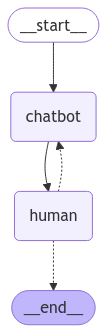

In [10]:
chat_with_human_graph = create_basic_chat()
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

5. Running the graph

In [14]:
def test_chat():
    """Test the basic chat implementation."""
    graph = create_basic_chat()
    
    # Initial state
    state = {
        "messages": [],      # Empty conversation
        "order": [],        # No orders yet
        "finished": False   # Conversation active
    }
    
    try:
        # Run the conversation
        final_state = graph.invoke(state)
        
        # Show results
        print("\nConversation Summary:")
        print(f"Total Messages: {len(final_state['messages'])}")
        print(f"Final Status: {'Completed' if final_state['finished'] else 'Active'}")
        
        # Print conversation history
        print("\nConversation History:")
        for msg in final_state["messages"]:
            # Check message type to determine if it's from bot or user
            if isinstance(msg, AIMessage):
                print(f"Bot: {msg.content}")
            else:
                print(f"User: {msg.content}")
        
    except Exception as e:
        print(f"Error in conversation: {e}")

test_chat()

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
Model: Here's our menu:

### Coffee
- Espresso
- Americano
- Latte
- Cappuccino
- Mocha
- Macchiato

### Tea
- Black Tea
- Green Tea
- Herbal Tea
- Chai Tea

### Other Beverages
- Hot Chocolate
- Iced Coffee
- Iced Tea

Would you like to know more about any of these drinks or place an order?
Model: An espresso is a strong and concentrated coffee made by forcing hot water through finely-ground coffee beans. It's typically served in small, 1-ounce shots.

Would you like to order an espresso, or do you have any specific preferences or questions about it?

Conversation Summary:
Total Messages: 6
Final Status: Completed

Conversation History:
Bot: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
User: what drinks do you have?
Bot: Here's our menu:

### Coffee
- Espresso
- Americano
- Latte
- Cappuccino
- Mocha
- Macchiato

### Tea
- Black Tea
- Green Tea
- Herbal Tea
- Chai Tea

#